In [1]:
import pandas as pd

df = pd.read_csv('Data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


In [2]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


In [3]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 7
Max phrase length (French): 16
Sequence length: 16


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer(oov_token='[UNK]')
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=sequence_len, padding='post')

fr_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n', oov_token='[UNK]') # Do not strip [] characters
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=sequence_len + 1, padding='post')

In [5]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6034
Vocabulary size (French): 12198


In [6]:
inputs = { 'encoder_inputs': en_x, 'decoder_inputs': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

## Build and train a model

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from keras_nlp.layers import TokenAndPositionEmbedding, TransformerEncoder, TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

embed_dim = 256
num_heads = 8

encoder_inputs = Input(shape=(None,), dtype='int64', name='encoder_inputs')
x = TokenAndPositionEmbedding(en_vocab_size, sequence_len, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, num_heads)(x)
encoder = Model(encoder_inputs, encoder_outputs)

decoder_inputs = Input(shape=(None,), dtype='int64', name='decoder_inputs')
encoded_seq_inputs = Input(shape=(None, embed_dim), name='decoder_state_inputs')
x = TokenAndPositionEmbedding(fr_vocab_size, sequence_len, embed_dim, mask_zero=True)(decoder_inputs)
x = TransformerDecoder(embed_dim, num_heads)(x, encoded_seq_inputs, use_causal_mask=True)
x = Dropout(0.5)(x)

decoder_outputs = Dense(fr_vocab_size, activation='softmax')(x)
decoder = Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

model = Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name='transformer'
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)

Model: "transformer"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 encoder_inputs (InputLayer)           [(None, None)]             0             []                                      
                                                                                                                        
 token_and_position_embedding (TokenAn  (None, None, 256)         1548800       ['encoder_inputs[0][0]']                
 dPositionEmbedding)                                                                                                    
                                                                                                                        
 decoder_inputs (InputLayer)           [(None, None)]             0             []                                      
           

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hist = model.fit(inputs, outputs, epochs=50, validation_split=0.2, callbacks=[callback])
#hist = model.fit(inputs, outputs, epochs=30, validation_split=0.2)

Epoch 1/50
1250/1250 [==============================] - 134s 106ms/step - loss: 1.3800 - accuracy: 0.4682 - val_loss: 1.0198 - val_accuracy: 0.5717
Epoch 2/50
1250/1250 [==============================] - 132s 105ms/step - loss: 0.9269 - accuracy: 0.6029 - val_loss: 0.8032 - val_accuracy: 0.6457
Epoch 3/50
1250/1250 [==============================] - 130s 104ms/step - loss: 0.7140 - accuracy: 0.6676 - val_loss: 0.6765 - val_accuracy: 0.6912
Epoch 4/50
1250/1250 [==============================] - 132s 106ms/step - loss: 0.5850 - accuracy: 0.7077 - val_loss: 0.6195 - val_accuracy: 0.7102
Epoch 5/50
1250/1250 [==============================] - 135s 108ms/step - loss: 0.4994 - accuracy: 0.7337 - val_loss: 0.5894 - val_accuracy: 0.7240
Epoch 6/50
1250/1250 [==============================] - 135s 108ms/step - loss: 0.4382 - accuracy: 0.7544 - val_loss: 0.5674 - val_accuracy: 0.7337
Epoch 7/50
1250/1250 [==============================] - 136s 108ms/step - loss: 0.3925 - accuracy: 0.7680 - val_

[]

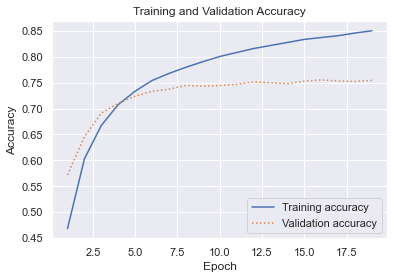

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [10]:
#model.save('Data/NMT_transformer_model')

In [13]:
import numpy as np

def translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup):
    input_sequence = en_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_sentence = '[start]'

    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences([decoded_sentence])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]
        
        prediction = model([padded_input_sequence, padded_target_sequence])

        sampled_token_index = np.argmax(prediction[0, i, :]) - 1
        sampled_token = fr_index_lookup[sampled_token_index]
        decoded_sentence += ' ' + sampled_token

        if sampled_token == '[end]':
            break
    
    return decoded_sentence[8:-6]

fr_vocab = fr_tokenizer.word_index
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
sentences = en[40000:40010].values

for sentence in sentences:
    translated = translate_text(sentence, model, en_tokenizer, fr_tokenizer, fr_index_lookup)
    print(f'{sentence} => {translated}')

its fall now => cest tombe maintenant
im losing => je suis en train de perdre
it was quite funny => cetait assez amusant
thats not unusual => ce nest pas inhabituel
i think ill do that => je pense que je vais faire ca
tom looks different => tom a lair different
its worth a try => ca vaut le coup dessayer
fortune smiled on him => la chance lui a souri
lets hit the road => taillons la route
i love winning => jadore gagner


In [16]:
text = 'Hello world'
translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup)

'salut tom'